In [166]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import sklearn

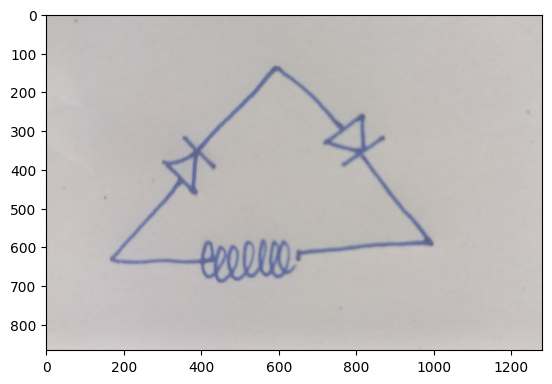

In [167]:
# loading image, chnaging layer sequence

img = cv2.imread('test_images/test4.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

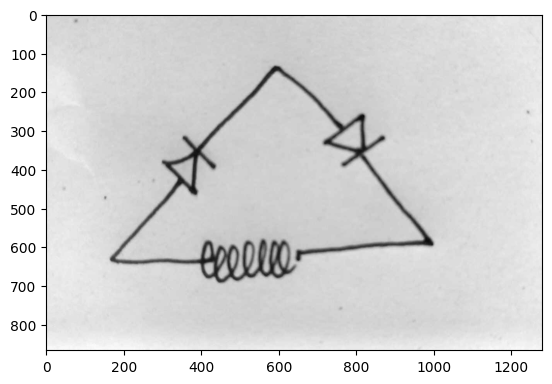

In [168]:
# converting to grey scale

grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(grey_img, cmap='gray')


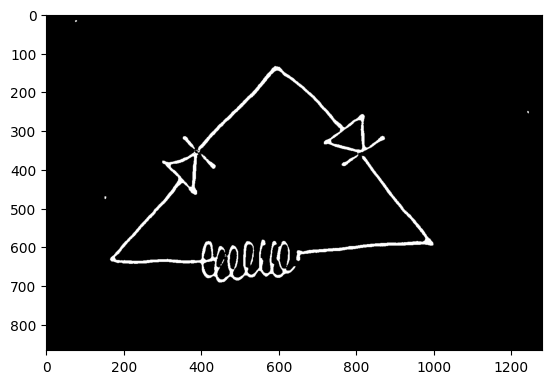

In [169]:
# applying threshold

th = cv2.adaptiveThreshold(grey_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 31, 21)
plt.imshow(th, cmap='gray')

# chnaged

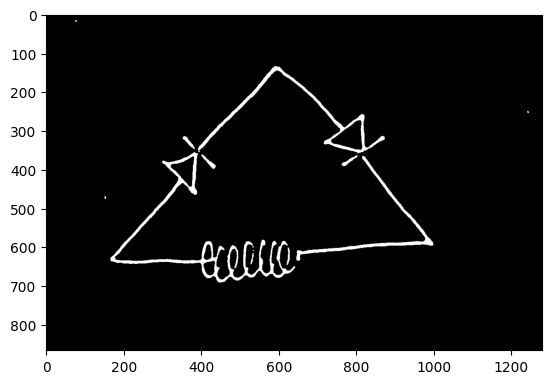

In [170]:
# opening & removing noise grain in background
# i.e. eroding the img and then dialating it

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening_img = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
plt.imshow(opening_img, cmap='gray')

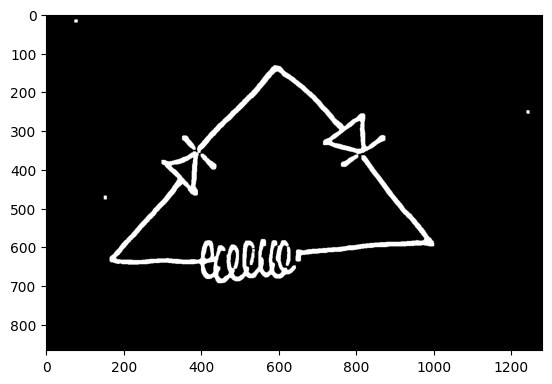

In [171]:
# dialating again to make line thicker

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
dline = cv2.dilate(opening_img, kernel, iterations=2)
plt.imshow(dline, cmap='gray')

In [172]:
# # Detect corners using the contours
# corners = cv2.goodFeaturesToTrack(image=dline,maxCorners=50,qualityLevel=0.40,minDistance=50)
 
# # Draw the corners on the original image
# for corner in corners:
#     x,y = corner.ravel()
#     cv2.circle(img,(int(x),int(y)),5,(255,0,0),10)

# plt.imshow(img)

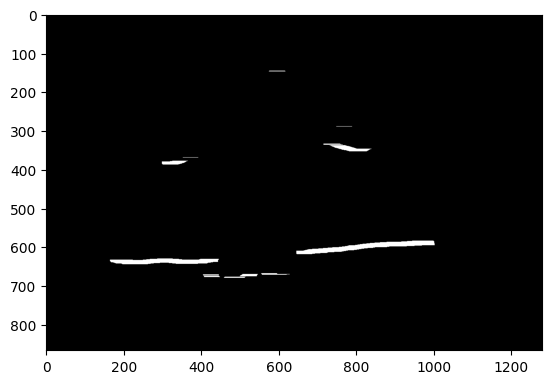

In [173]:
# finding horizontal edges
h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
h_edges = cv2.morphologyEx(dline, cv2.MORPH_OPEN, h_kernel, iterations=1)
plt.imshow(h_edges, cmap='gray')

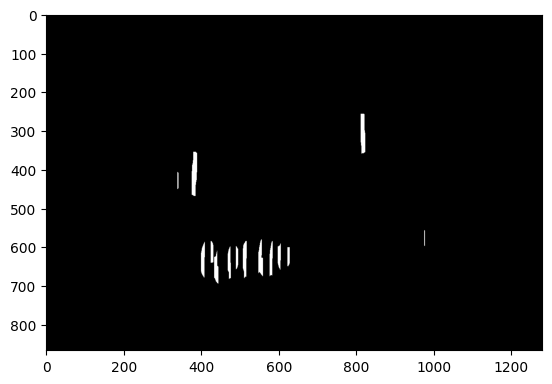

In [174]:
# finding vertical edges
v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,40))
v_edges = cv2.morphologyEx(dline, cv2.MORPH_OPEN, v_kernel, iterations=1)
plt.imshow(v_edges, cmap='gray')

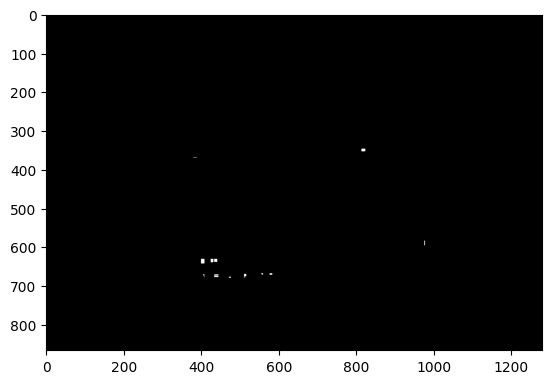

In [175]:
intersect1 = cv2.bitwise_and(h_edges, v_edges)
plt.imshow(intersect1, cmap='gray')

# changed

(105, 130, 99)
(33, 154, 126)
(130, 144, 50)


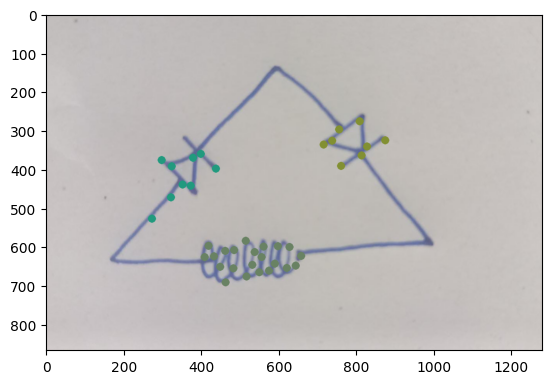

In [176]:
anchor_points = cv2.goodFeaturesToTrack(image=dline,maxCorners=50,qualityLevel=0.30,minDistance=20)

# Convert the anchor points to a numpy array
anchor_points = np.float32(anchor_points.reshape((-1, 2)))

# Perform DBSCAN clustering on the anchor points
clustering = DBSCAN(eps=80, min_samples=3).fit(anchor_points)

# Get the labels for the clusters
labels = clustering.labels_

# Find the unique labels and their counts
unique_labels, counts = np.unique(labels, return_counts=True)

# Get the index of the label with the highest count
max_count_idx = np.argmax(counts)

# Get the points in the cluster with the highest count
max_count_points = anchor_points[labels == unique_labels[max_count_idx]]

# Draw circles around the points in the cluster with the highest count
img2 = img.copy()
for l in unique_labels:
    if l == -1: continue
    px = [int(i[0]) for i in anchor_points[labels == l]]
    py = [int(i[1]) for i in anchor_points[labels == l]]
    color = np.random.choice(range(256), size=3)
    color = (int (color [ 0 ]), int (color [ 1 ]), int (color [ 2 ]))
    print(color)
    for i in range(len(px)):
        cv2.circle(img2, (px[i], py[i]), 5, color=tuple(color), thickness=10)
    
plt.imshow(img2)
plt.show()

In [177]:
sorted(counts)

[8, 8, 9, 22]

In [178]:
anchor_points[labels == unique_labels[max_count_idx]]

array([[550., 665.],
       [419., 597.],
       [483., 655.],
       [433., 624.],
       [621., 654.],
       [449., 651.],
       [644., 648.],
       [532., 646.],
       [556., 626.],
       [538., 613.],
       [462., 610.],
       [628., 600.],
       [561., 599.],
       [485., 608.],
       [409., 626.],
       [598., 598.],
       [463., 691.],
       [517., 676.],
       [575., 661.],
       [590., 643.],
       [658., 623.],
       [515., 584.]], dtype=float32)

In [179]:
components_extracted = []

# chnaged

In [180]:
remove_comp = dline.copy()
rects = []
rects_contour = []
for l,_ in enumerate(counts):
    if l == 0: continue
    px = [int(i[0]) for i in anchor_points[labels == unique_labels[l]]]
    py = [int(i[1]) for i in anchor_points[labels == unique_labels[l]]]
    if abs(max(py)-min(py))*abs(max(px)-min(px)) > 700:
        components_extracted.append(dline[min(py)-15:max(py)+15, min(px)-15:max(px)+15])
        remove_comp[min(py)-15:max(py)+15, min(px)-15:max(px)+15] = 0    
        rects_contour.append((np.array([[min(px)-15, min(py)-15],[max(px)+15, min(py)-15],[max(px)+15, max(py)+15],[min(px)-15, max(py)+15]])))
        rects.append([min(px)-22,max(px)+22,min(py)-22,max(py)+22])

In [181]:
rects

[[387, 680, 562, 713], [251, 460, 338, 549], [694, 897, 254, 413]]

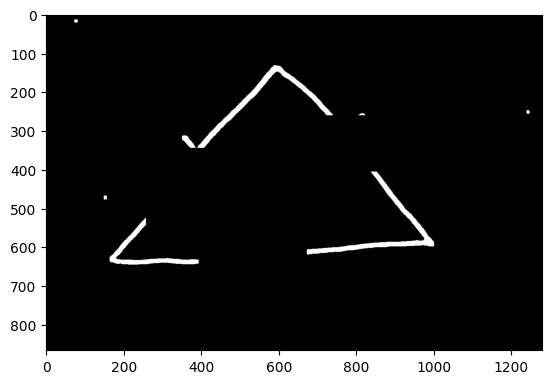

In [182]:
plt.imshow(remove_comp, cmap='gray')

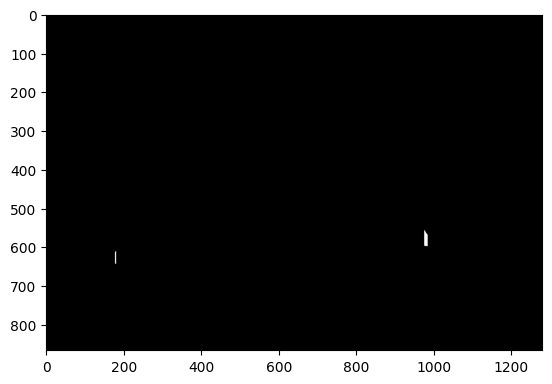

In [183]:
# finding vertical edges
v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,30))
v_edges = cv2.morphologyEx(remove_comp, cv2.MORPH_OPEN, v_kernel, iterations=1)
plt.imshow(v_edges, cmap='gray')

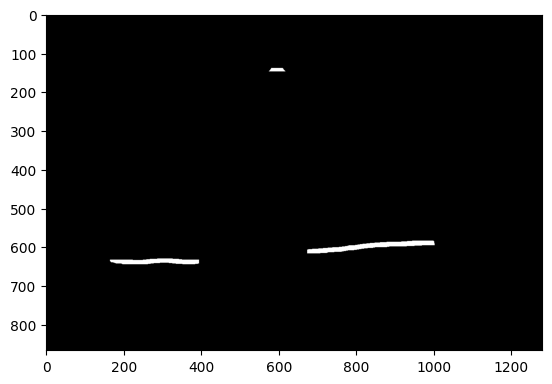

In [184]:
# finding horizontal edges
h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30,1))
h_edges = cv2.morphologyEx(remove_comp, cv2.MORPH_OPEN, h_kernel, iterations=1)
plt.imshow(h_edges, cmap='gray')

In [185]:
# cnts = cv2.findContours(intersect1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# for c in cnts:
#     # Find centroid and draw center point
#     M = cv2.moments(c)
#     cx = int(M['m10']/M['m00'])
#     cy = int(M['m01']/M['m00'])
#     cv2.circle(img, (cx, cy), 5, (255,255,255), 10)

# chnaged

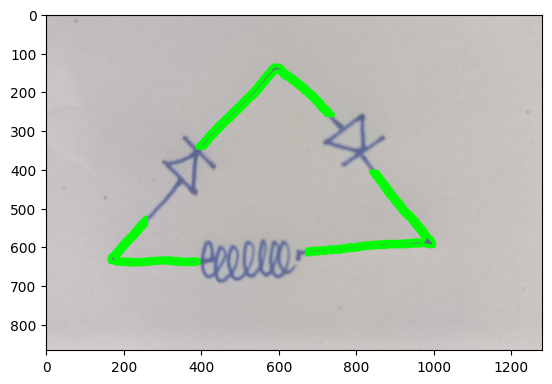

In [186]:
# draw contours on removed component pic

contour = img.copy()
cnts = cv2.findContours(remove_comp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
filtered_cnts = [c for c in cnts[0] if cv2.contourArea(c) > 600]
cv2.drawContours(contour, filtered_cnts, -1, (0,255,0), 10)
plt.imshow(contour, cmap='gray')

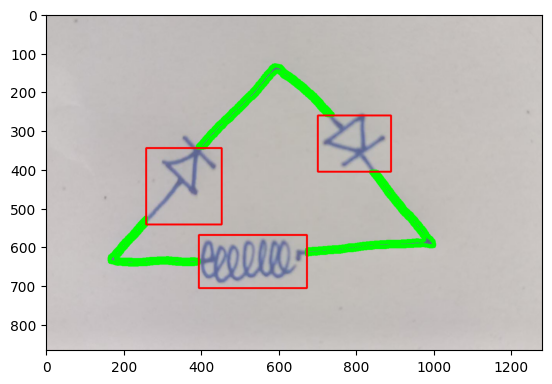

In [187]:
cv2.drawContours(contour, tuple(rects_contour), -1, (255,0,0), 3)
plt.imshow(contour, cmap='gray')

In [188]:
wiring_dict = {}
last_key = 0
for c in filtered_cnts:
    for rect in rects:
        for p in c:
            # rect[0] is xmin, rect[1] is xmax, rect[2] is ymin, rect[3] is ymax
            # p[0][0] is x, p[0][1] is y
            if p[0][0] >= rect[0] and p[0][0] <= rect[1] and p[0][1] >= rect[2] and p[0][1] <= rect[3]:
                if last_key not in wiring_dict.keys():
                    wiring_dict[last_key] = [rect]
                else:
                    wiring_dict[last_key].append(rect)
                break
    last_key += 1
                

# chnaged

In [189]:
wiring_dict

{0: [[387, 680, 562, 713], [251, 460, 338, 549]],
 1: [[387, 680, 562, 713], [694, 897, 254, 413]],
 2: [[251, 460, 338, 549], [694, 897, 254, 413]]}

In [190]:
key = 0
dict_len = len(wiring_dict)
del_wire = []

In [191]:
while key < dict_len:
    if len(wiring_dict[key]) == 1:
        del_wire.append(key)
        del wiring_dict[key]
    key += 1

In [192]:
wiring_dict

{0: [[387, 680, 562, 713], [251, 460, 338, 549]],
 1: [[387, 680, 562, 713], [694, 897, 254, 413]],
 2: [[251, 460, 338, 549], [694, 897, 254, 413]]}

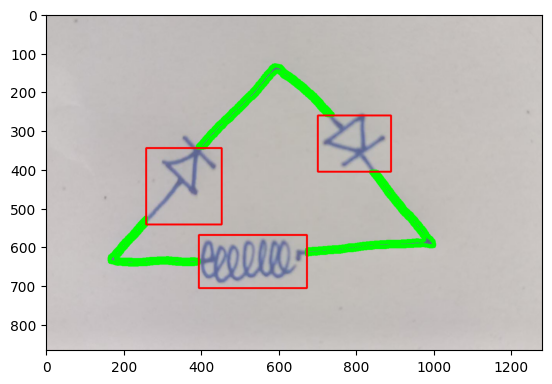

In [193]:
img4 = img.copy()

for i in del_wire:
    del filtered_cnts[i]

cv2.drawContours(img4, filtered_cnts, -1, (0,255,0), 10)
cv2.drawContours(img4, tuple(rects_contour), -1, (255,0,0), 3)
plt.imshow(img4, cmap='gray')

True

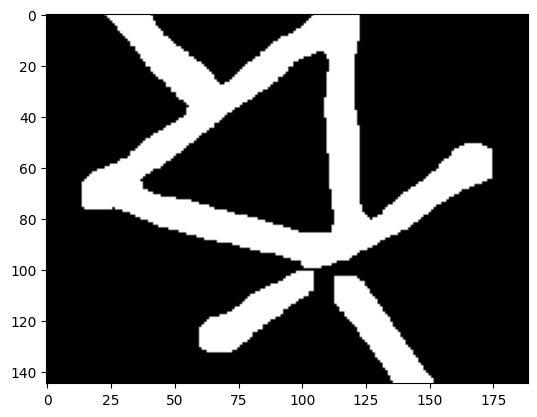

In [198]:
plt.imshow(components_extracted[2], cmap='gray')
cv2.imwrite('test_images/classify7.jpeg', components_extracted[2])

In [195]:
rects

[[387, 680, 562, 713], [251, 460, 338, 549], [694, 897, 254, 413]]